In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

from directed_graph_generators.directed_stochastic_block_model import DirectedStochasticBlockModel
from clustering_algorithms.zanetti_clustering import DSBM_Clustering_Zanetti

In [2]:
# create function that maps clusters to partitions of nodes 1 to n
def cluster_to_partition(clusters):
    partition = {}
    for i in range(len(clusters)):
        if clusters[i] in partition:
            partition[clusters[i]].append(i)
        else:
            partition[clusters[i]] = [i]
    return partition

# function to compute volume of cluster
def volume(cluster, A):
    return np.sum(A[cluster,:]) + np.sum(A[:,cluster])

def flow_ratio_two_clusters(cluster_A, cluster_B, A):
    return np.sum(A[cluster_A,:][:,cluster_B])/(volume(cluster_A,A) + volume(cluster_B,A))

def flow_ratio(partition, A):
    flow_ratio = 0
    for cluster_A in partition:
        for cluster_B in partition:
            #if cluster_A != cluster_B:
            flow_ratio += flow_ratio_two_clusters(partition[cluster_A], partition[cluster_B], A)
    return flow_ratio

def construct_new_adjacency_matrix_using_flow_ratio_for_edge_weights(A, partitions):
    # compute flow ratio for each partition
    flow_ratios = []
    flow_ratios_matrix = np.zeros((len(partitions),len(partitions)))
    for partition1 in partitions:
        for partition2 in partitions:
            flow_ratios_matrix[partitions.index(partition1),partitions.index(partition2)] = flow_ratio_two_clusters(partition1, partition2, A)
    # making hermitian A using flow ratios:
    # subtact lower triangle from upper triangle
    normalized_flow_ratios_matrix = np.triu(flow_ratios_matrix) - np.tril(flow_ratios_matrix).T 
    normalized_flow_ratios_matrix = normalized_flow_ratios_matrix/np.sum(np.abs(normalized_flow_ratios_matrix))
    normalized_flow_ratios_matrix = normalized_flow_ratios_matrix - normalized_flow_ratios_matrix.T
    normalized_flow_ratios_matrix = np.exp(normalized_flow_ratios_matrix*2*(np.pi)*1j)

    A_hermitian = np.zeros(A.shape, dtype=complex)
    for partition1 in partitions:
        for partition2 in partitions:
            for node1 in partition1:
                for node2 in partition2:
                    if A[node1,node2] != 0:
                        A_hermitian[node1,node2] = normalized_flow_ratios_matrix[partitions.index(partition1),partitions.index(partition2)]

    return A_hermitian, normalized_flow_ratios_matrix

In [17]:
#create a directed stochastic block model
n = 100
p = 0.5
q = 0.5
#3 x 3 block model
F = [[0.5,0.8,0.8,0.8],
     [0.2,0.5,0.8,0.5],
     [0.2,0.2,0.5,0.8],
     [0.2,0.5,0.2,0.5]]
dsbm = DirectedStochasticBlockModel(k=4, N=n, p=p, q=q, F=F)
A = dsbm.adjacency_matrix

ARI for k = 4:  0.5792151162790697
ARI for k = 4:  0.5792151162790697
ARI for adjusted clustering:  0.6756890903676251


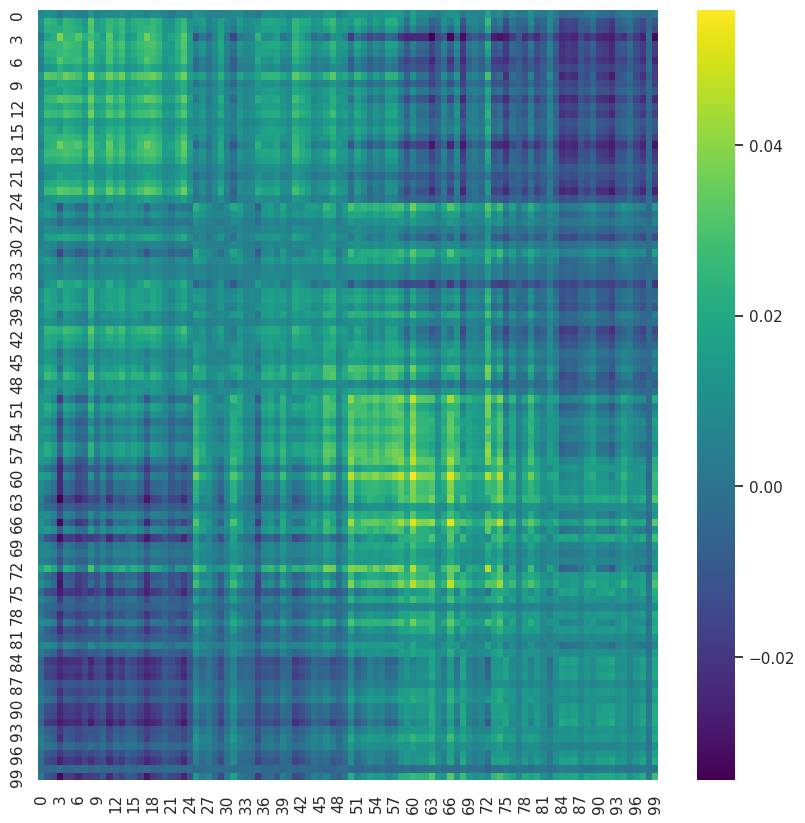

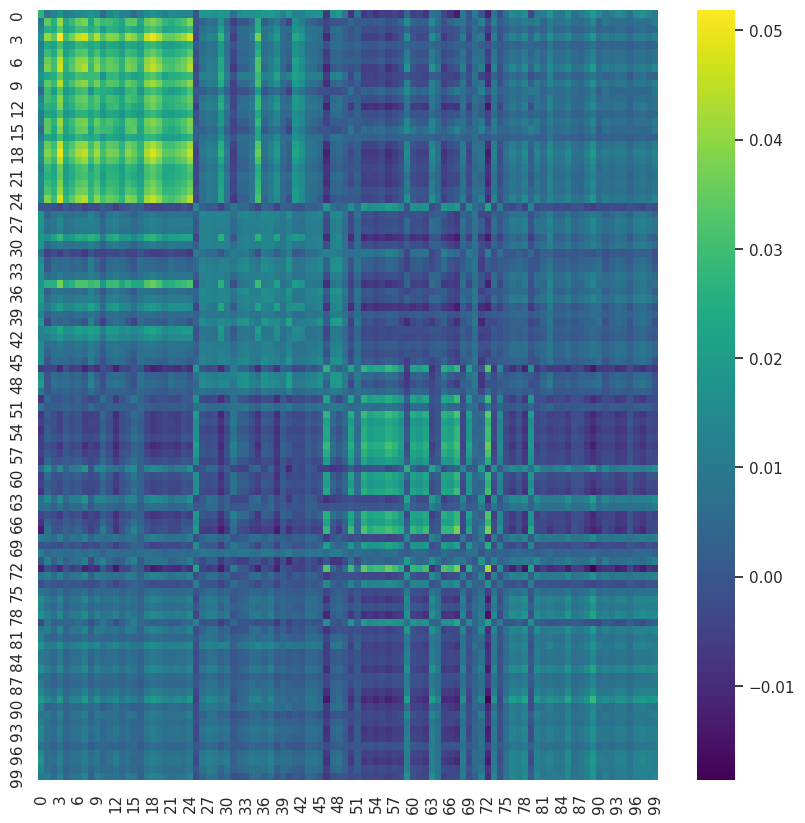

In [18]:
#cluster
K=4
l=2

clusters_i,projected_evecs_zanetti = DSBM_Clustering_Zanetti(A,K=K,l=l,method='adjacency',normalize=False, roots_of_unity = K)
#check ARI
print('ARI for k = 4: ',adjusted_rand_score(dsbm.correct_clusters,clusters_i))

#Constructing new matrix
A_herm, normalized_flows = construct_new_adjacency_matrix_using_flow_ratio_for_edge_weights(A, list(cluster_to_partition(clusters_i).values()))


def new_clustering(A_herm, K,l):
     # applying spectral clustering to A_herm
     e_vals,e_vecs = np.linalg.eig(A_herm)
     # take real part of eigenvalues to get rid of machine errors
     e_vals = np.real(e_vals)
     # sort eigenvalues and eigenvectors
     idx = e_vals.argsort()[::-1]
     e_vals = e_vals[idx]
     e_vecs = e_vecs[:,idx]

     e_vecs_projected = np.zeros((len(A),len(A)))

     for k in range(l):
          e_vecs_projected = e_vecs_projected + np.outer(e_vecs[:,k],e_vecs[:,k].conj()) 

     e_vecs_projected  = np.real(e_vecs_projected)

     kmeans = KMeans(n_clusters = K,n_init=25, random_state = 42).fit(e_vecs_projected)
     clusters_adjusted = kmeans.labels_
     return clusters_adjusted, e_vecs_projected


clusters_adjusted, projected_evecs_new = new_clustering(A_herm, K=K,l=2)

#print ARI
Standard_ARI = adjusted_rand_score(dsbm.correct_clusters,clusters_i)
new_ARI = adjusted_rand_score(dsbm.correct_clusters,clusters_adjusted)
print('ARI for k = 4: ',Standard_ARI)
print('ARI for adjusted clustering: ',new_ARI)

#plotting heatmaps of projected_evecs_zanetti and projected_evecs_new and saving to folder
sns.set()
plt.figure(figsize=(10,10))
sns.heatmap(projected_evecs_zanetti, cmap='viridis')
plt.savefig('/home/georg/directed-graph-clustering/experiments/4x4blockmodel/Zanetti.png')
plt.figure(figsize=(10,10))
sns.heatmap(projected_evecs_new, cmap='viridis')
plt.savefig('/home/georg/directed-graph-clustering/experiments/4x4blockmodel/New.png')


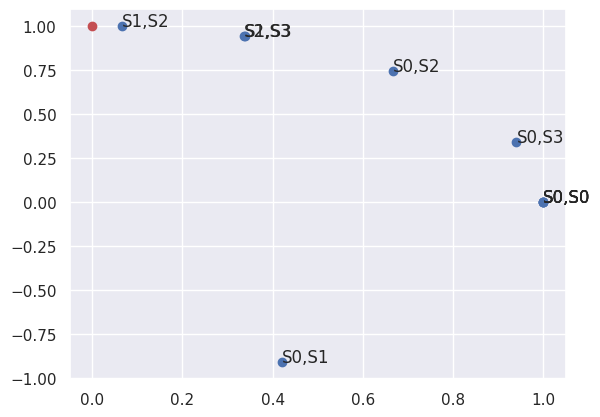

In [19]:
## Examining what the flow ratios look like
upper_tri_part = np.triu(normalized_flows)
normalized_flows_flattened = upper_tri_part.flatten()
# remove zeros
normalized_flows_flattened = normalized_flows_flattened[normalized_flows_flattened != 0]
# plot real and imaginary part of normalized flows
plt.scatter(np.real(normalized_flows_flattened),np.imag(normalized_flows_flattened))
# add kth root of unity
k =4
plt.scatter(np.real(np.exp((2*np.pi*1j)/k)),np.imag(np.exp((2*np.pi*1j)/k)),color='r')
# label each coordinate with matrix row and column
for i in range(len(normalized_flows_flattened)):
    # find row and column of each element
    row = np.where(upper_tri_part == normalized_flows_flattened[i])[0][0]
    col = np.where(upper_tri_part == normalized_flows_flattened[i])[1][0]
    plt.annotate(f'S{row},S{col}', (np.real(normalized_flows_flattened[i]), np.imag(normalized_flows_flattened[i])))
    #add grid
    plt.grid(True)
plt.savefig('/home/georg/directed-graph-clustering/experiments/4x4blockmodel/flow_ratios.png')

In [8]:
#construct dsbm
k = 3
n = 150
p = 0.5
q = 0.5
F = [[0.5,0.8,0.2],[0.2,0.5,0.8],[0.8,0.2,0.5]]
dsbm = DirectedStochasticBlockModel(k=3, N=n, p=p, q=q, F=F)
A = dsbm.adjacency_matrix

ARI for k = 3:  1.0
ARI for adjusted clustering:  1.0


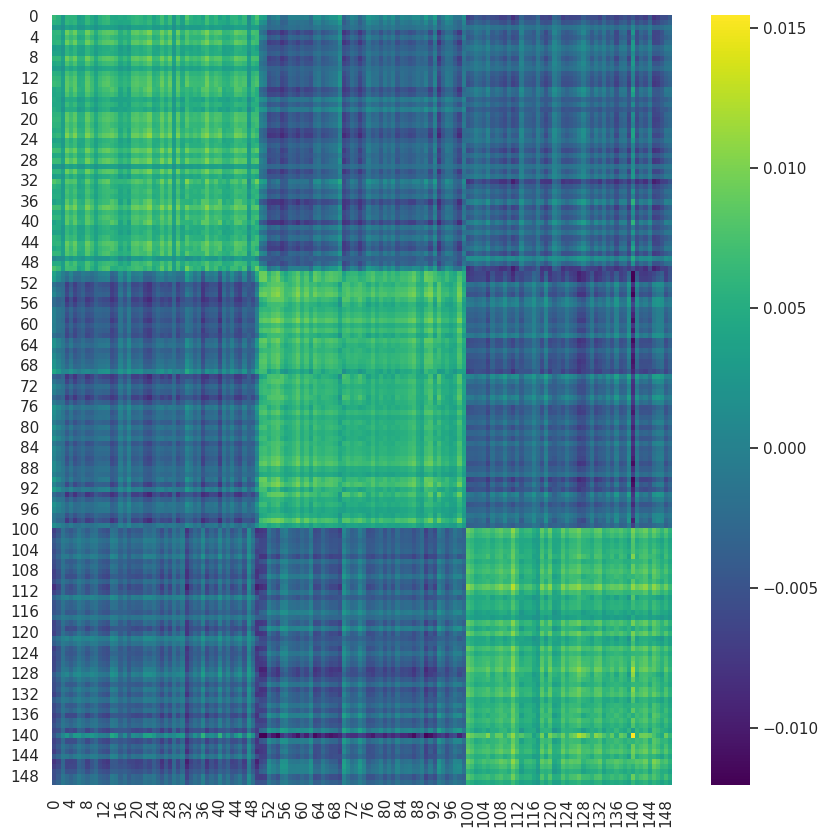

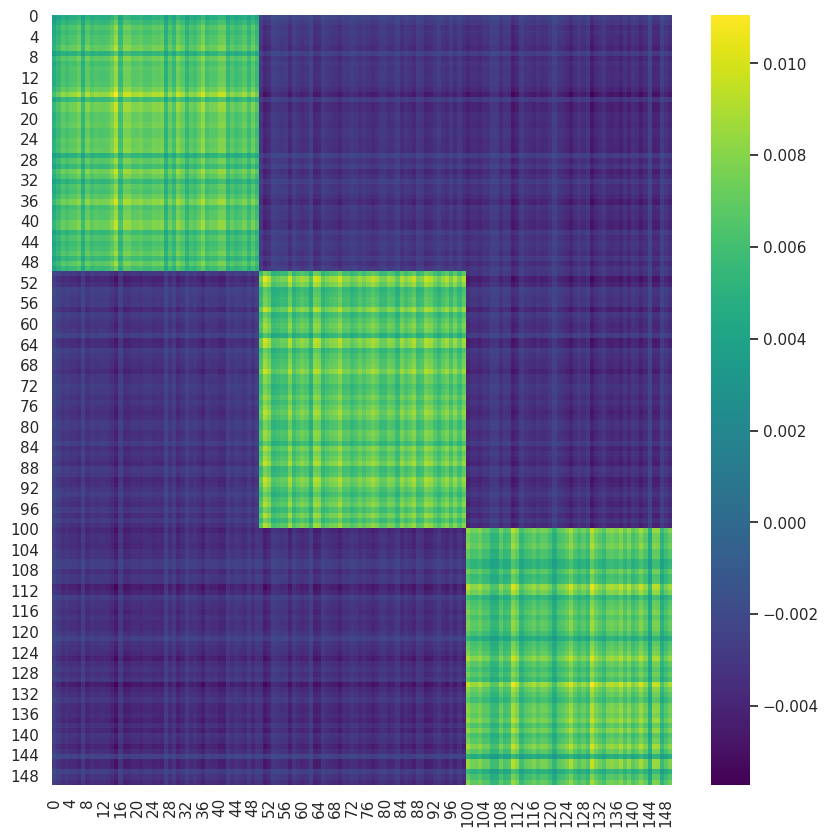

In [9]:
#cluster
K=3
l=1

clusters_standard, projected_evecs_zanetti = DSBM_Clustering_Zanetti(adjacency_matrix=A,K=K,l=l,method='adjacency',normalize=True, roots_of_unity = 4)

#Constructing new matrix
A_herm, normalized_flows = construct_new_adjacency_matrix_using_flow_ratio_for_edge_weights(A, list(cluster_to_partition(clusters_standard).values()))
clusters_adjusted, projected_evecs_new = new_clustering(A_herm, K=K,l=l)

#print ARI
Standard_ARI = adjusted_rand_score(dsbm.correct_clusters,clusters_standard)
new_ARI = adjusted_rand_score(dsbm.correct_clusters,clusters_adjusted)
print('ARI for k = 3: ',Standard_ARI)
print('ARI for adjusted clustering: ',new_ARI)

#plotting heatmaps of projected_evecs_zanetti and projected_evecs_new and saving to folder
sns.set()
plt.figure(figsize=(10,10))
sns.heatmap(projected_evecs_zanetti, cmap='viridis')
plt.savefig('/home/georg/directed-graph-clustering/experiments/3cycle/Zanetti.png')
plt.figure(figsize=(10,10))
sns.heatmap(projected_evecs_new, cmap='viridis')
plt.savefig('/home/georg/directed-graph-clustering/experiments/3cycle/New.png')


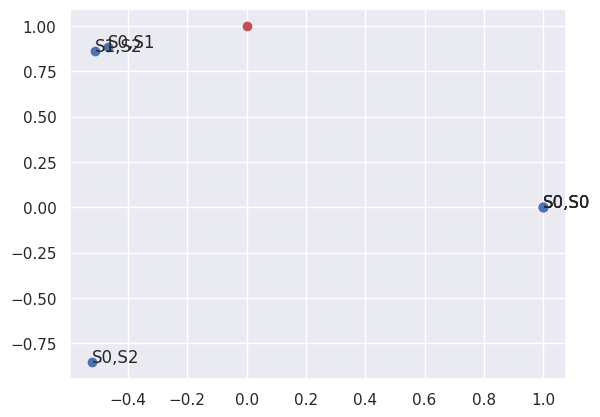

In [10]:
## Examining what the flow ratios look like
upper_tri_part = np.triu(normalized_flows)
normalized_flows_flattened = upper_tri_part.flatten()
# remove zeros
normalized_flows_flattened = normalized_flows_flattened[normalized_flows_flattened != 0]
# plot real and imaginary part of normalized flows
plt.scatter(np.real(normalized_flows_flattened),np.imag(normalized_flows_flattened))
# add kth root of unity
k =4
plt.scatter(np.real(np.exp((2*np.pi*1j)/k)),np.imag(np.exp((2*np.pi*1j)/k)),color='r')
# label each coordinate with matrix row and column
for i in range(len(normalized_flows_flattened)):
    # find row and column of each element
    row = np.where(upper_tri_part == normalized_flows_flattened[i])[0][0]
    col = np.where(upper_tri_part == normalized_flows_flattened[i])[1][0]
    plt.annotate(f'S{row},S{col}', (np.real(normalized_flows_flattened[i]), np.imag(normalized_flows_flattened[i])))
    #add grid
    plt.grid(True)
plt.savefig('/home/georg/directed-graph-clustering/experiments/3cycle/flow_ratios.png')

In [11]:
#construct dsbm
k = 6
n = 300
p = 0.5
q = 0.5
F = [[0.5,0.9,0.9,0.5,0.5,0.5],
     [0.1,0.5,0.9,0.5,0.5,0.5],
     [0.1,0.1,0.5,0.9,0.5,0.5],
     [0.5,0.5,0.1,0.5,0.9,0.9],
     [0.5,0.5,0.5,0.1,0.5,0.9],
     [0.5,0.5,0.5,0.1,0.1,0.5]]
dsbm = DirectedStochasticBlockModel(k=k, N=n, p=p, q=q, F=F)
A = dsbm.adjacency_matrix

ARI for k = 3:  0.9091283737534042
ARI for adjusted clustering:  0.9528315229689975


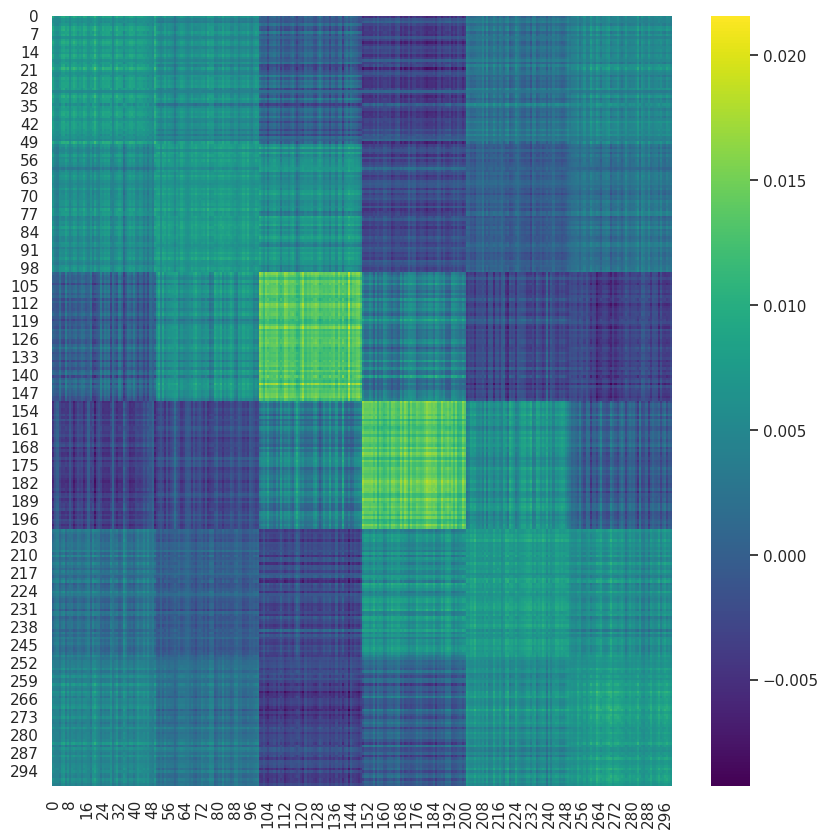

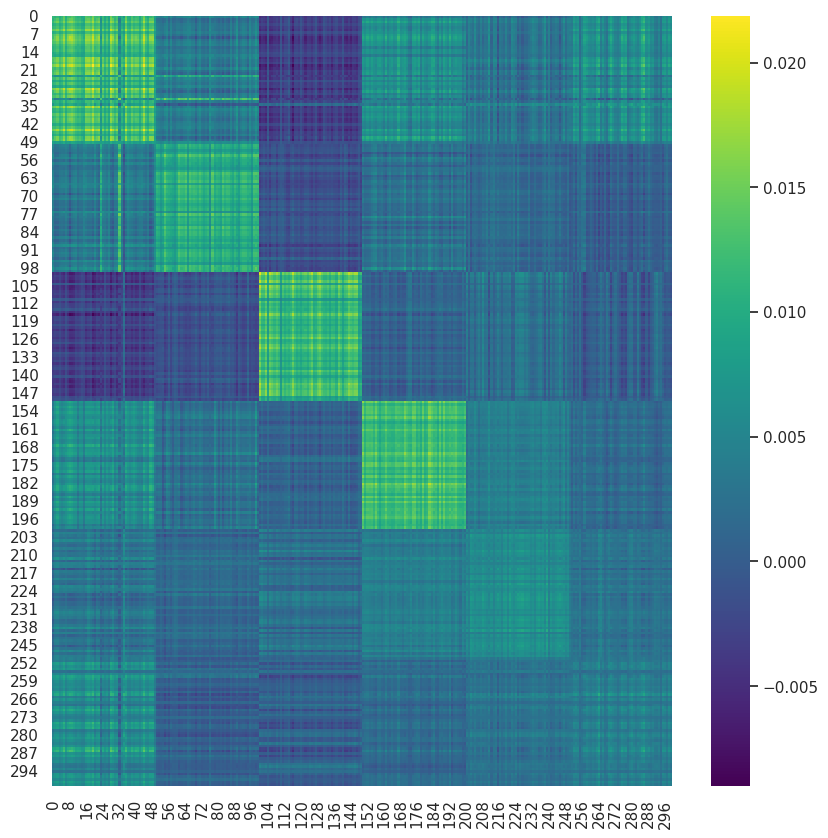

In [12]:
#cluster
K=6
l=3

clusters_standard, projected_evecs_zanetti = DSBM_Clustering_Zanetti(adjacency_matrix=A,K=K,l=l,method='adjacency',normalize=True, roots_of_unity = 6)

#Constructing new matrix
A_herm, normalized_flows = construct_new_adjacency_matrix_using_flow_ratio_for_edge_weights(A, list(cluster_to_partition(clusters_standard).values()))
clusters_adjusted, projected_evecs_new = new_clustering(A_herm, K=K,l=l)

#print ARI
Standard_ARI = adjusted_rand_score(dsbm.correct_clusters,clusters_standard)
new_ARI = adjusted_rand_score(dsbm.correct_clusters,clusters_adjusted)
print('ARI for k = 3: ',Standard_ARI)
print('ARI for adjusted clustering: ',new_ARI)

#plotting heatmaps of projected_evecs_zanetti and projected_evecs_new and saving to folder
sns.set()
plt.figure(figsize=(10,10))
sns.heatmap(projected_evecs_zanetti, cmap='viridis')
plt.savefig('/home/georg/directed-graph-clustering/experiments/6blockmodel/Zanetti.png')
plt.figure(figsize=(10,10))
sns.heatmap(projected_evecs_new, cmap='viridis')
plt.savefig('/home/georg/directed-graph-clustering/experiments/6blockmodel/New.png')

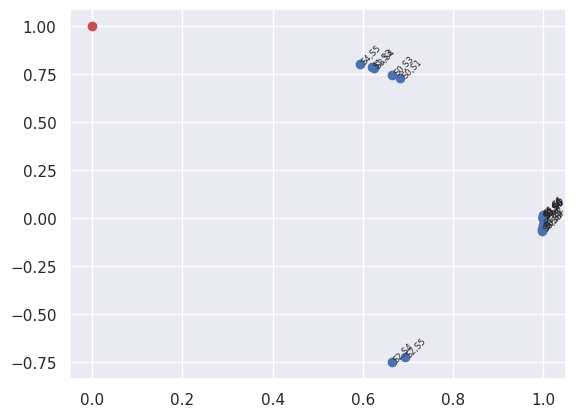

In [13]:
## Examining what the flow ratios look like
upper_tri_part = np.triu(normalized_flows)
normalized_flows_flattened = upper_tri_part.flatten()
# remove zeros
normalized_flows_flattened = normalized_flows_flattened[normalized_flows_flattened != 0]
# plot real and imaginary part of normalized flows
plt.scatter(np.real(normalized_flows_flattened),np.imag(normalized_flows_flattened))
# add kth root of unity
k =4
plt.scatter(np.real(np.exp((2*np.pi*1j)/k)),np.imag(np.exp((2*np.pi*1j)/k)),color='r')
# label each coordinate with matrix row and column
for i in range(len(normalized_flows_flattened)):
    # find row and column of each element
    row = np.where(upper_tri_part == normalized_flows_flattened[i])[0][0]
    col = np.where(upper_tri_part == normalized_flows_flattened[i])[1][0]
    plt.annotate(f'S{row},S{col}', (np.real(normalized_flows_flattened[i]), np.imag(normalized_flows_flattened[i])),size=6,rotation=45)
    #add grid
    plt.grid(True)
plt.savefig('/home/georg/directed-graph-clustering/experiments/6blockmodel/flow_ratios.png')